# Resilient Tube

In [1]:
from csv import reader
from igraph import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from random import choice

In [2]:
df = pd.read_csv("InputData_Edges.csv")
dfedge = df[['Station_from', 'Station_to', 'Name']]
tuples = [tuple(x) for x in dfedge.values]

In [3]:
ptn = Graph.TupleList(tuples, directed=True, vertex_name_attr="name", edge_attrs="line")
ptn["name"] = "PTN London Underground"
ptn.summary()

'IGRAPH DN-- 280 731 -- PTN London Underground\n+ attr: name (g), name (v), line (e)'

**Create target list by floooding**

In [4]:
df2 = pd.read_csv("InputData_Stations.csv")
flood = df2[['name','FloodRisk1000a']]
threshold = flood['name'][flood.FloodRisk1000a > 0.3]
targets = []

for i in threshold:
    targets.append(i)

ptn2 = ptn
targets

['BARONS_COURT',
 'BOND_STREET',
 'BURNT_OAK',
 'KENSINGTON_(OLYMPIA)',
 'LANCASTER_GATE',
 'MOOR_PARK',
 'NEASDEN',
 'SOUTH_KENTON',
 'THEYDON_BOIS',
 'WESTBOURNE_PARK']

In [5]:
# Proting function

def plot_hist(tup, target):
    sns.set(context="notebook", font_scale=1.2)
    plt.figure(facecolor="white", figsize=(9, 6), dpi=300)
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Path Length distribution station: %s' % str(target))
    plt.bar(*zip(*tup))

**Delete nodes based on Flood Risk**

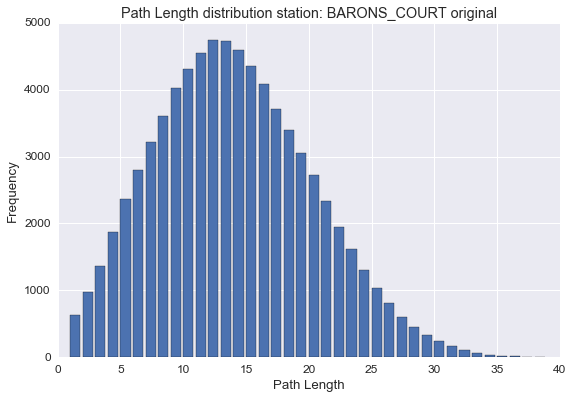

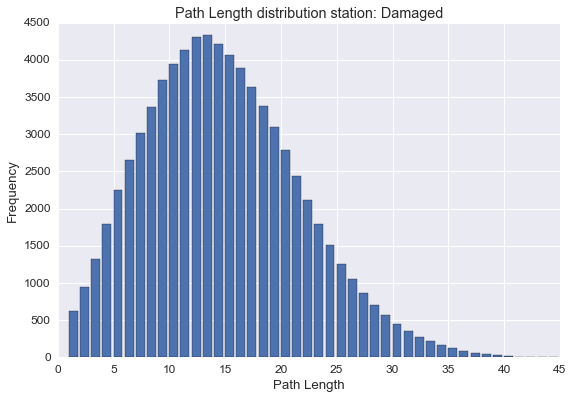

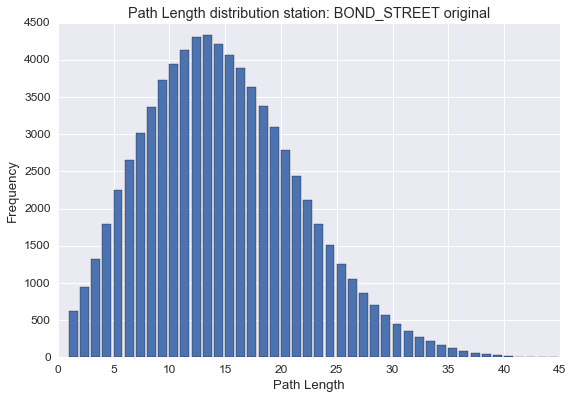

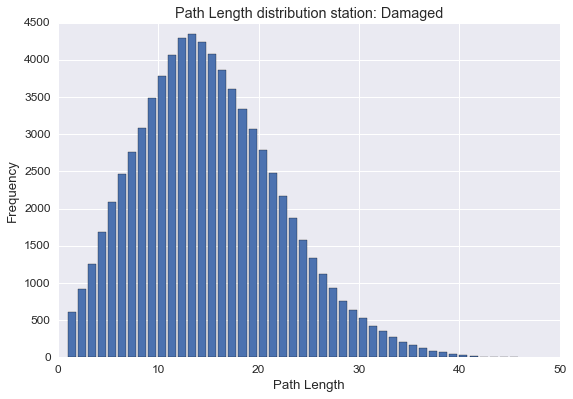

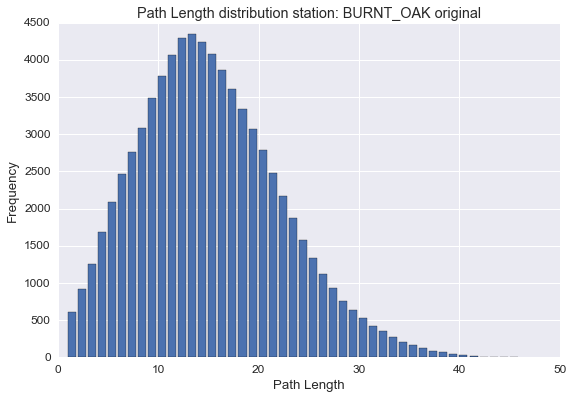

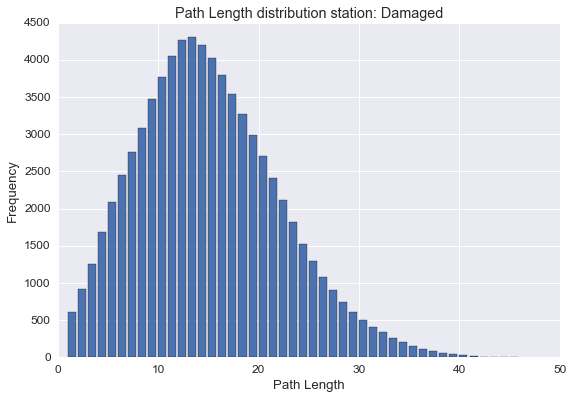

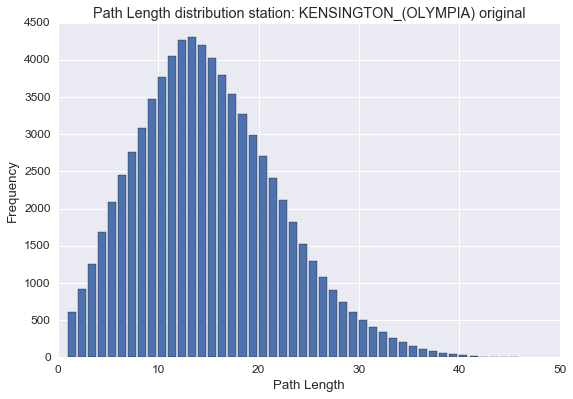

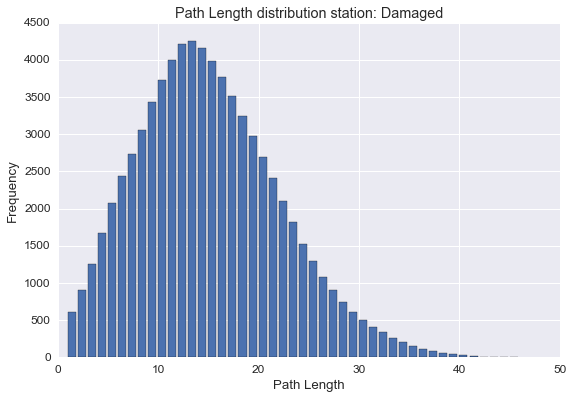

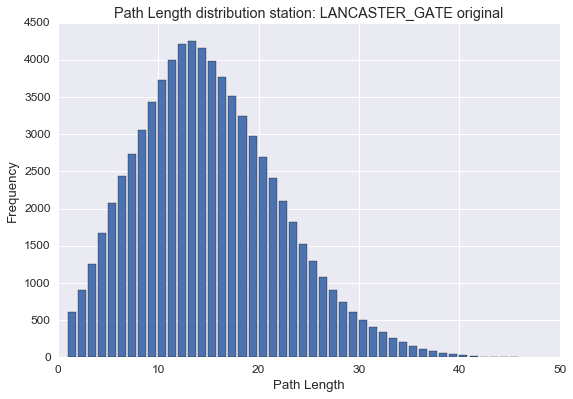

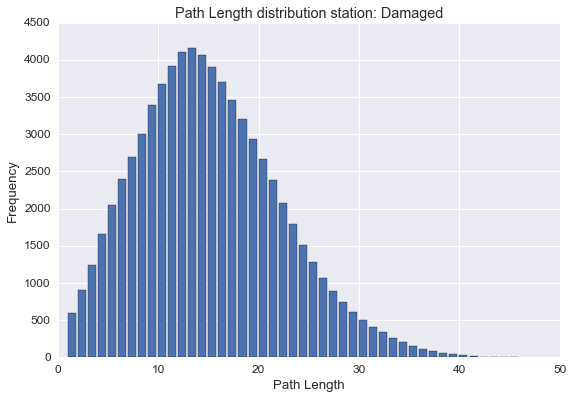

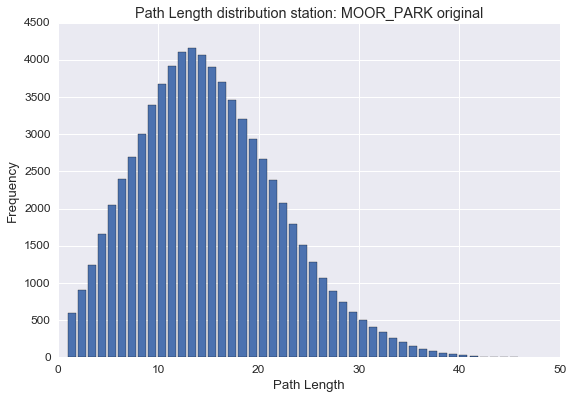

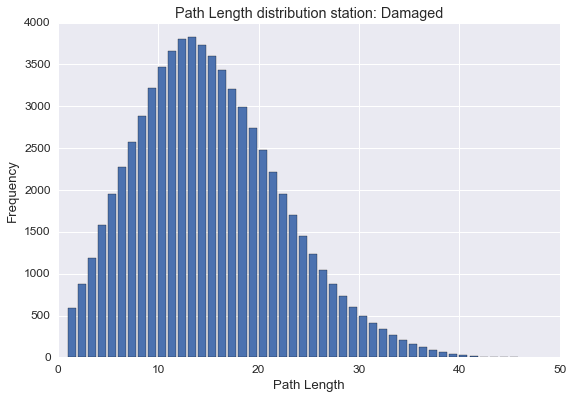

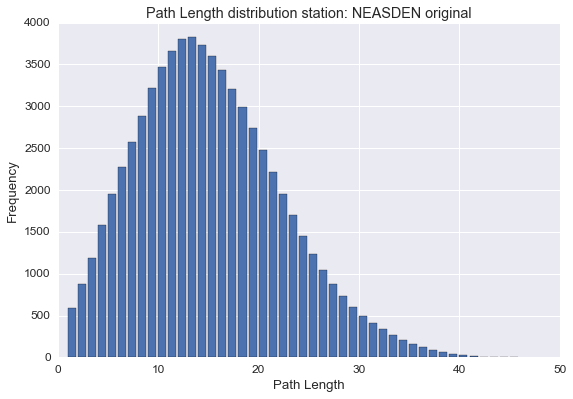

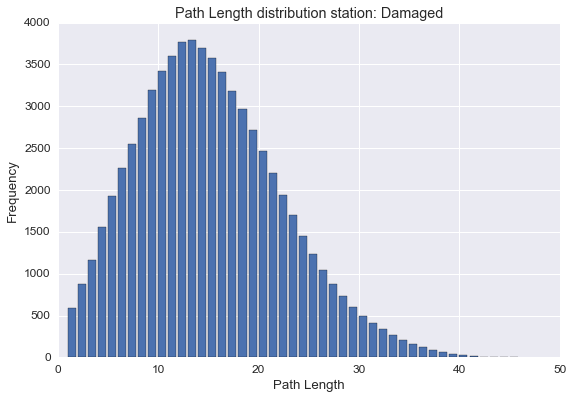

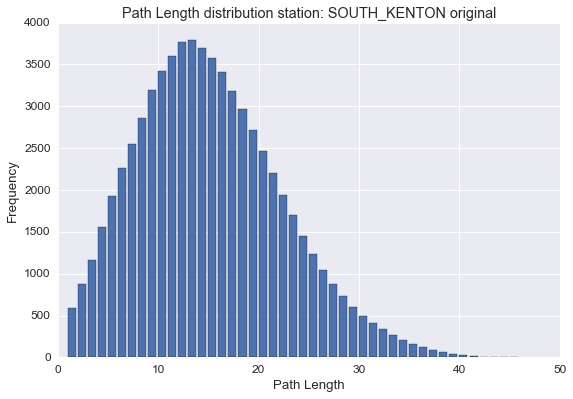

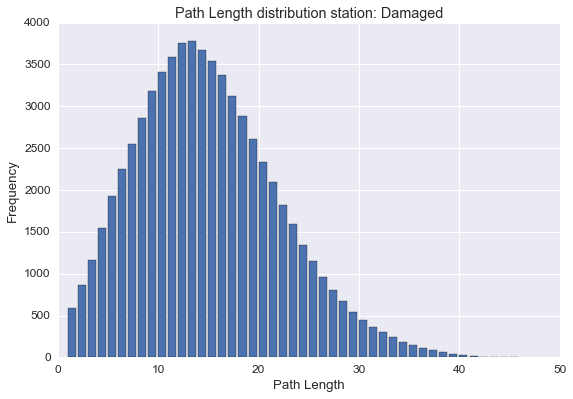

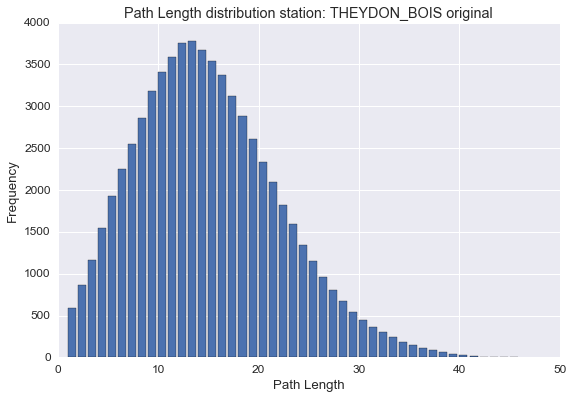

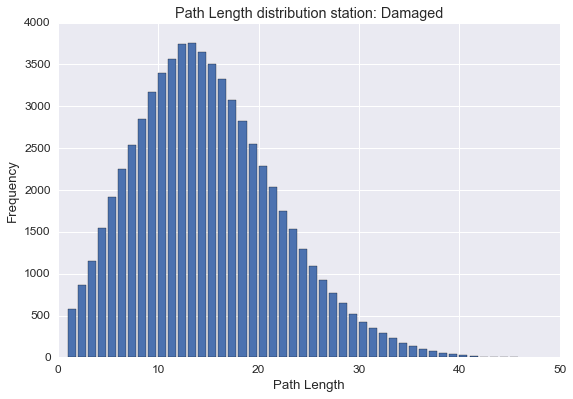

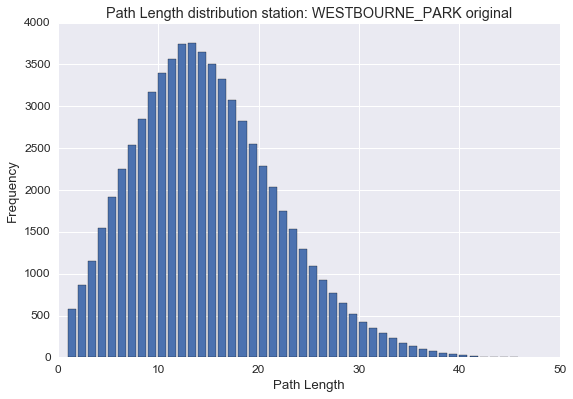

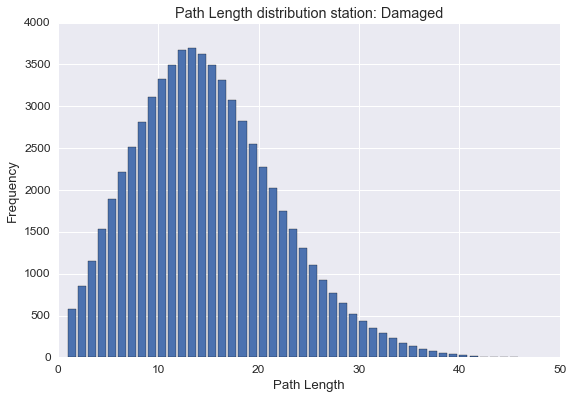

In [6]:
% matplotlib inline

for i in targets:
    path_hist_orig = list(ptn.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn.delete_vertices(ptn.vs.find(name=i))
    path_hist_dell = list(ptn.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    
    plot_hist(hist_dell, 'Damaged')

**Delete nodes based on Betweeness Centrality**

In [ ]:
for vertex in ptn2.vs:
    vertex["beetw_cent"] = ptn2.betweenness(vertex, directed=True)

In [ ]:
% matplotlib inline

count = 0

while count <= 10:
    max_bc = max(ptn2.vs['beetw_cent'])
    target = ptn2.vs(ptn2.vs['beetw_cent'] == max_bc)['name']
    
    path_hist_orig = list(ptn2.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn2.delete_vertices(ptn2.vs.find(name=i))
    path_hist_dell = list(ptn2.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    plot_hist(hist_dell, 'Damaged')
    
    count += 1

In [ ]:
# # df2.loc[df2['name'] == 'ALDGATE', 'FloodRisk1000a']
# # list1 = np.array(df2[['name','FloodRisk1000a']])
# # risk = list1['FloodRisk1000a'][df2['name'] == node["name"]]

# for node in ptn.vs:
#     risk = df2['FloodRisk1000a'][df2['name'] == node['name']]
#     print(risk)

In [ ]:
# # Add flooding risk probability
# df2 = pd.read_csv("InputData_Stations.csv")
# df2risk = df2['FloodRisk1000a', 'name']
# for node in ptn.vs:
#     risk = df2['FloodRisk1000a'][df2['name'] == node['name']]
# #     if type(risk) == pd.series
#     node['floodrisk'] = risk
#     print(risk)

In [ ]:
# % matplotlibe inline
# layout = ptn.layout_kamada_kawai()
# plot(ptn, layout = layout)